In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyextremes import get_return_periods
import seaborn as sns
import matplotlib.lines as mlines

Use Latex Font

In [2]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "axes.labelsize": 14,               # Font size for labels
    "font.size": 11,                    # General font size
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

# Methodology

We will be applying the method on the 1979-2023 time series for atlite onshore wind generation.

In [3]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

In [4]:
df_combine = pd.read_csv('../Data/cf_combine_7923.csv',
                         index_col=0,
                         parse_dates=True
)

df_combine_avg = df_combine.rolling('D', min_periods=24, center=True).mean()

In [5]:
droughts_dict = {}

for column in df_combine_avg:
    for th in np.linspace(0, 0.2, 9):
        raw_droughts = identify_drought(df_combine_avg[column], 0.1)
        droughts = raw_droughts[raw_droughts > 24]
        droughts_df = pd.DataFrame(droughts)
        droughts_df = droughts_df.set_axis([column], axis=1)
        droughts_dict[column] = droughts_df

## Plot

In [6]:
def my_title(ax, title):
    ax.set_title(title, 
                 x=0.5, y=1,
                 pad = -18,
                #  transform=ax.transAxes,
                 fontsize=16, 
                 bbox=dict(facecolor='white', alpha=1, edgecolor='white')
    )

In [ ]:
label_name = ['Atlite', 'C3S-E Gridded', 'C3S-E National']
title_name = ['c) Wind', 'b) PV', 'c) Existing', 'd) Balanced']
color_models = ['#B03024', '#348ABD', '#988ED5']
sign_models = [':', '--', '-']

In [25]:
# Group datasets based on categories
categories = {
    'onshorewind': ['onshorewind_atlite', 'onshorewind_c3se_gridded', 'onshorewind_c3se_national'],
    'pv': ['pv_atlite', 'pv_c3se_gridded', 'pv_c3se_national'],
    'combine_2023': ['combine_atlite_2023', 'combine_c3se_gridded_2023', 'combine_c3se_national_2023'],
    'combine_2030': ['combine_atlite_2030', 'combine_c3se_gridded_2030', 'combine_c3se_national_2030']
}

### Multiple

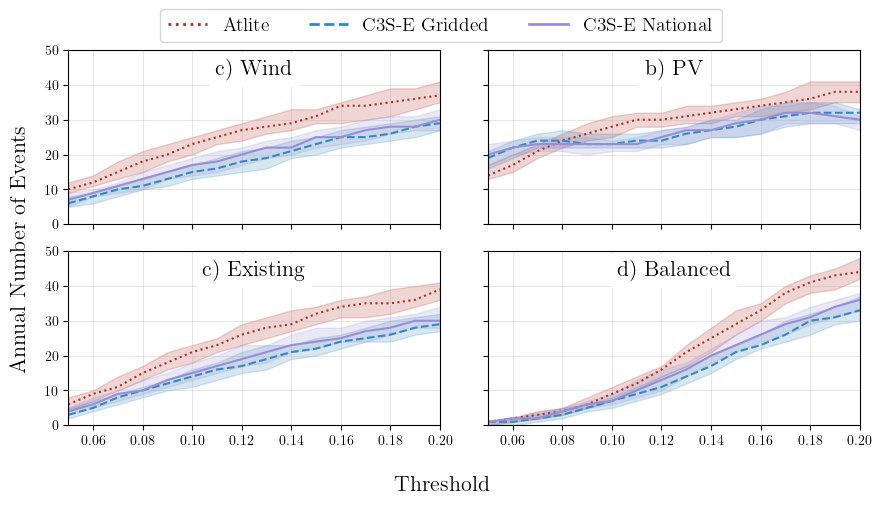

In [30]:
thresholds = np.arange(0.05, 0.21, 0.01) # Coarse
# thresholds = np.arange(0, 0.301, 0.001) # Fine

fig, axs = plt.subplots(2, 2,
                       sharex=True,
                       sharey=True,
                       figsize=(9,5)
)
axs = axs.flatten()

# Loop over title_name
for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]

    # Loop over the three models
    for i, name in enumerate(datasets_in_category):

        median_num_events_year = []
        q1_num_events_year = []
        q3_num_events_year = []

        # Loop over threhsolds
        for th in thresholds:
            series = df_combine_avg[name]

            raw_droughts = identify_drought(series, th)
            droughts = raw_droughts[raw_droughts > 24] 

            # Calculate the number of events per year
            if droughts.empty:
                median_num_events_year.append(0)
                q1_num_events_year.append(0)
                q3_num_events_year.append(0)
            else:
                events_year = droughts.resample('Y').count()

                # Median
                median_events_year = events_year.quantile(0.5)
                median_num_events_year.append(median_events_year)
                # Q1
                q1_events_year = events_year.quantile(0.25)
                q1_num_events_year.append(q1_events_year)
                # Q3
                q3_events_year = events_year.quantile(0.75)
                q3_num_events_year.append(q3_events_year)

        # Plot line
        ax.plot(thresholds, median_num_events_year,
                color = color_models[i],
                ls = sign_models[i],
                zorder = 2)
        
        # Plot shaded area
        ax.fill_between(thresholds, q1_num_events_year, q3_num_events_year,
                        color = color_models[i],
                        alpha =0.2,
                        zorder = 1)
        
    my_title(ax, title_name[idx])
    ax.grid(True, alpha=0.3, zorder=0)
    ax.margins(0.02)
    # x-axis
    ax.set_xlim(thresholds[0], thresholds[-1])
    # y-axis
    ax.set_ylim(0,50)

# Legend
handles = [mlines.Line2D([], [], color=color_models[i], label=label_name[i], lw=2, ls=sign_models[i]) for i in range(len(color_models))]
fig.legend(handles = handles,
           loc = 'upper center',
           ncol = 3, 
           markerscale = 2,
           fontsize = 14)

fig.supxlabel('Threshold', fontsize = 16)
fig.supylabel('Annual Number of Events', fontsize = 16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig('../Figures/droughts_varying_threshold.png', dpi=300)